In [1]:
# Загрузка зависимостей
import numpy
import pandas
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

Using TensorFlow backend.


In [2]:
# Загрузка подготовленного набора данных
dataset = pandas.read_csv('prepared_data.csv') # Убедиться в правильности пути к файлу!
dataset.head(10) # Вывод первых 10 строк

,Unnamed: 0,MMIN,CHMAX,2,4,5,6,8,adviser,amdahl,...,microdata,nas,ncr,nixdorf,perkin-elmer,prime,siemens,sperry,sratus,wang
0,0,0.251074,1.000000,0.445334,0.730638,1.000000,0.894427,0.759257,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.874463,0.676123,0.119215,1.000000,0.433861,0.632456,0.825801,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,0.874463,0.676123,0.119215,1.000000,0.433861,0.632456,0.782136,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,0.874463,0.676123,0.119215,1.000000,0.433861,0.632456,0.728689,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,0.874463,0.478091,0.119215,0.888465,0.433861,0.632456,0.671211,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5,0.874463,0.676123,0.094840,1.000000,0.613572,0.632456,0.862138,0,1,...,0,0,0,0,0,0,0,0,0,0
6,6,1.000000,0.676123,0.067473,1.000000,0.613572,0.894427,0.893257,0,1,...,0,0,0,0,0,0,0,0,0,0
7,7,1.000000,0.676123,0.067473,1.000000,0.613572,0.894427,0.955579,0,1,...,0,0,0,0,0,0,0,0,0,0
8,8,1.000000,0.676123,0.067473,1.000000,0.613572,0.894427,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
9,9,1.000000,0.956183,0.067473,1.000000,0.867722,1.000000,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Выделение входных и выходных параметров:
# Выходной параметр - значение столбца обработанного набора данных, соответсвующее столбцу №8 из первоначального набора данных (machine.data.csv).
# Входные параметры - все остальные столбцы обработанного набора данных.
# Используем .values, чтобы индексы не попали в новые переменные и в дальнейшем не мешали нам, например, при построении графиков.
X = dataset.iloc[:, 1:37].values
Y = dataset['8'].values

# Обратите внимание на структуру вашего обработанного файлы и измените индексы, если нужно.

In [4]:
# Разделение данных на обучающую и тестовую выборки:
# Используем метод train_test_split библиотеки sklearn.
# Он разделяет заданные массивы входных и выходных параметров на две части каждый.
# Значение test_size определяет долю тестовой выборки в исходных данных.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [5]:
# Задаем параметры структуры нейронной сети.

# Количество нейронов во входном слое должно быть равно количеству входных параметров.
input_layer_size = 36

# Количество нейронов в каждом скрытом слое и количество таких слоёв могут быть выбраны произвольно.
# Увеличение числа нейронов относительно предыдущего слоя позволяет лучше обрабатывать отдельные примеры.
# Уменьшение числа нейронов относительно предыдущего слоя позволяет обощать информацию и выводить новые правила.
# Увеличение числа слоёв помогает сети работать как более сложная функция.
first_hidden_layer_size = 5


# Количество нейронов в выходном слое должно быть равно количеству выходных параметров.
output_layer_size = 1

# Параметры обучения нейронной сети: количество эпох и размер батча.
epochs_number = 100
batch_size = 16

In [6]:
# Создание нейронной сети прямого распространения, пока она пустая, т.е. не содержит слоёв и нейронов.
model = Sequential()

# Входной слой и первый скрытый слой, функция активации - ReLU
model.add(Dense(first_hidden_layer_size, input_dim=input_layer_size, activation='relu'))

# Выходной слой, функция активации - линейная, т.к. решается задача регрессии.
model.add(Dense(output_layer_size, activation='linear'))

In [7]:
# Обзор нейронной сети, теперь в ней есть слои и нейроны.
# Если внимательно посмотреть на количество параметров, т.е. связей между нейронами, то можно увидеть, что автоматически добавлены нейроны смещения.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 185       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Настройка нейронной сети.
# Функция потерь (loss) - среднеквадратическая ошибка.
# Оптимизатор (optimizer) - adam (в настоящий момент - это стандартный оптимизатор).
# Указываем метрики средняя абсолютная ошибка (mean_absolute_error) и среднеквадратическая ошиба (mean_squared_error) для дальнейшего анализа.
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])

In [9]:
# Обучение нейронной сети.
# На вход передаем обучающие и тестовые выборки, количество эпох и размер батча.
# На выходе получаем объект с историей обучения, который далее будем анализировать.
history = model.fit(X_train, Y_train, validation_data = (X_test,Y_test), epochs=epochs_number, batch_size=batch_size)

Train on 167 samples, validate on 42 samples
Epoch 1/100
167/167 [==============================] - 0s 1ms/step - loss: 0.0915 - mean_absolute_error: 0.2537 - mean_squared_error: 0.0915 - val_loss: 0.0690 - val_mean_absolute_error: 0.2304 - val_mean_squared_error: 0.0690
Epoch 2/100
167/167 [==============================] - 0s 164us/step - loss: 0.0652 - mean_absolute_error: 0.2130 - mean_squared_error: 0.0652 - val_loss: 0.0563 - val_mean_absolute_error: 0.1982 - val_mean_squared_error: 0.0563
Epoch 3/100
167/167 [==============================] - 0s 397us/step - loss: 0.0576 - mean_absolute_error: 0.1983 - mean_squared_error: 0.0576 - val_loss: 0.0508 - val_mean_absolute_error: 0.1845 - val_mean_squared_error: 0.0508
Epoch 4/100
167/167 [==============================] - 0s 164us/step - loss: 0.0530 - mean_absolute_error: 0.1891 - mean_squared_error: 0.0530 - val_loss: 0.0455 - val_mean_absolute_error: 0.1739 - val_mean_squared_error: 0.0455
Epoch 5/100
167/167 [====================

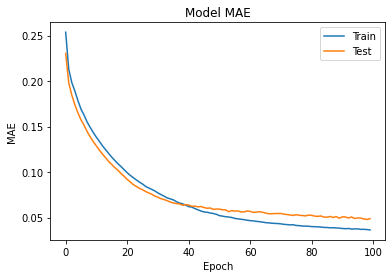

In [10]:
# Выводим динамику среднего абсолютного отклонения от номера эпохи обучения.
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error']) 
plt.title('Model MAE') 
plt.ylabel('MAE') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

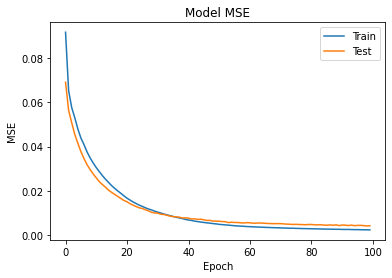

In [11]:
# Выводим динамику среднеквадратического отклонения, т.е. значения функции потерь, от номера эпохи обучения.
# Видно, что в процессе обучения сеть с каждой эпохой вычисляет всё более точные прогнозы значений Y.
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error']) 
plt.title('Model MSE') 
plt.ylabel('MSE') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

In [12]:
# Предсказание уже обученной нейронной сети на обучающей выборке:
Y_pred_train = model.predict(X_train).flatten()

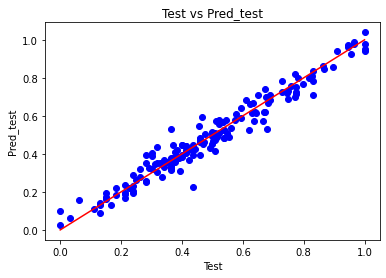

In [13]:
# Сравним эталонные значения Y_train и результат работы обученной нейронной сети Y_pred_train для обучающей выборки.
# В идеальной ситуации они должны совпадать, т.е. точки (Y_train[i], Y_pred_train[i]) должны лежать на прямой Y_train = Y_pred_train.
plt.plot(Y_train, Y_pred_train, 'bo')
plt.plot([0,1], [0,1], 'r-')
plt.title('Test vs Pred_test') 
plt.ylabel('Pred_test') 
plt.xlabel('Test') 
plt.show()

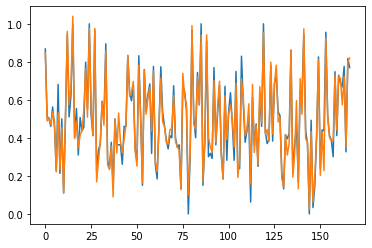

In [14]:
# Выведем сами значения Y_train и Y_pred_train.
plt.plot(Y_train)
plt.plot(Y_pred_train)
plt.show()

In [15]:
# Таким образом, обучение по обучающей выборке проведено.
# Теперь проверим работу нейроной сети на тестовой выборке.

# Предсказание обученной нейронной сети на тестовой выборке:
Y_pred_test = model.predict(X_test).flatten()

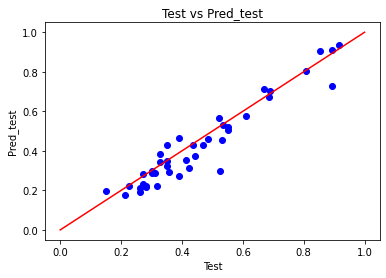

In [16]:
# Сравним эталонные значения Y_test и результат работы обученной нейронной сети Y_pred_test для тестовой выборки.
plt.plot(Y_test, Y_pred_test, 'bo')
plt.plot([0,1], [0,1], 'r-')
plt.title('Test vs Pred_test') 
plt.ylabel('Pred_test') 
plt.xlabel('Test') 
plt.show()

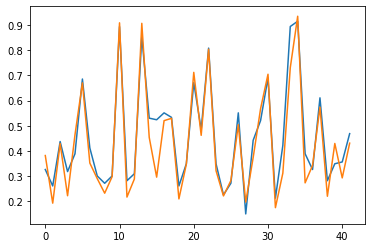

In [17]:
# Выведем сами значения Y_test и Y_pred_test.
plt.plot(Y_test)
plt.plot(Y_pred_test)
plt.show()

In [18]:
# Итого, качество работы нейронной сети на тестовых данных ниже, чем на обучающих - это ожидаемо.
# Тем не менее, нейронная сеть способна найти зависимости и предсказвать значение Y по X с приемлемым уровенм точности.

# Сравним среднеквадратичные ошибки (значения функции потерь) для обучающей и тестовой выборок.
print(numpy.sqrt(mean_squared_error(Y_train, Y_pred_train)))
print(numpy.sqrt(mean_squared_error(Y_test, Y_pred_test)))

0.04916475763955206
0.06598618364889305


In [19]:
# Проверим на нормальное распределение разности пар (Y_train, Y_pred_train), (Y_test, Y_pred_test)
# Для этого используем библиотеку scipy и метод stats.shapiro.
k_train, p_train = stats.shapiro(Y_train - Y_pred_train)
print('Train k = {0}, p = {1}'.format(k_train, p_train))

k_test, p_test = stats.shapiro(Y_test - Y_pred_test)
print('Test k = {0}, p = {1}'.format(k_test, p_test))

Train k = 0.970649003982544, p = 0.001304395031183958
Test k = 0.95096755027771, p = 0.06995256245136261


In [20]:
# Для полной выборки (Y, Y_pred) применим два статистических теста: shapiro и normaltest.
Y_pred = model.predict(X).flatten()

k_s, p_s = stats.shapiro(Y - Y_pred)
print('k_s = {0}, p_s = {1}'.format(k_s, p_s))

k_n, p_n = stats.normaltest(Y - Y_pred)
print('k_n = {0}, p_n = {1}'.format(k_n, p_n))

k_s = 0.9657299518585205, p_s = 5.878897354705259e-05
k_n = 24.08350873717437, p_n = 5.892946866130636e-06


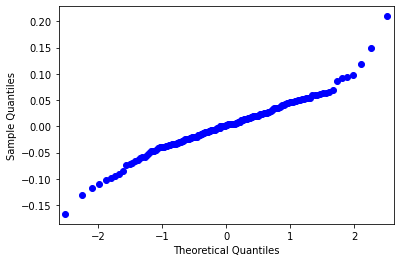

In [21]:
# И тоже самое визуально, с помощью грфиков квантиль-квантиль.
# Обучающая выборка
qqplot(Y_train - Y_pred_train)
plt.show()

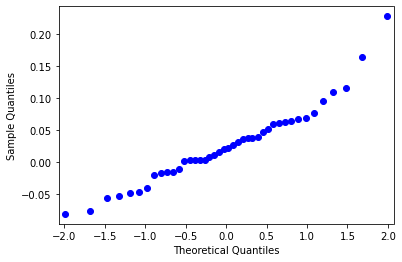

In [22]:
# Тестовая выборка
qqplot(Y_test - Y_pred_test)
plt.show()

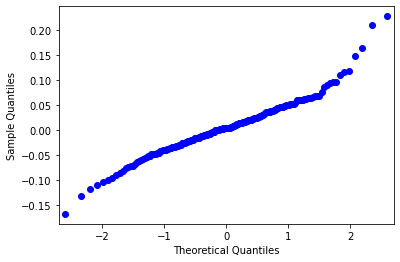

In [23]:
# Полная выборка
qqplot(Y - Y_pred)
plt.show()

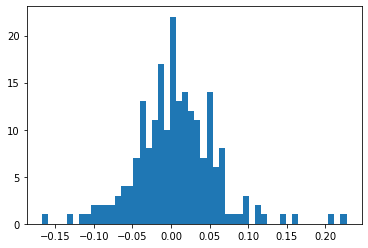

In [24]:
# Можо также визульно убедиться, что распределения "почти нормальное".
plt.hist(Y - Y_pred, bins=50)
plt.show()

In [25]:
# Сохраним обученную нейронную сеть, название файла можно выбрать любое, расширение - h5.
model.save('SimpleNeuralNetwork.h5')